In [1]:
import tensorflow
import time
from scipy.io import wavfile
from IPython.display import Audio
from IPython.core.display import display
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import librosa
import librosa.display
#from folder_locations import  data_folder, bird_train, bird_test, human_folder, human_clips_folder, warblr_folder
import os
#import plotly.express as px
#import sweetviz as sv
from sklearn.utils import shuffle
import pickle
import random

#locations
#data_folder = " "
ssd = os.getcwd()[:2]+"//"
warblr_folder = ssd+"warblr/" #+ data-folder
wav_folder = warblr_folder +"wav/"
human_folder = ssd+"cv-corpus-7.0-2021-07-21/en/"
hclip_folder = human_folder + "clips/"


random_number = 93
bird_sr = librosa.get_samplerate(warblr_folder + 'wav/000e088a-69f7-4d7a-ba7b.wav')
human_sr = librosa.get_samplerate(hclip_folder + 'common_voice_en_1.mp3')

In [2]:
#read the csv file of warblr
df_yesbirdy = pd.read_csv('yesbirdy.csv', index_col=0)
df_human = pd.read_csv('human.csv', index_col=0)

#create mixed dataframe
df_mixed = pd.concat([df_yesbirdy,df_human], axis=1)

In [3]:
with open('yesbirdy.pkl','rb') as file:
    birdy_dict = pickle.load(file)


In [4]:
#birdy_arr = np.memmap('yesbirdy.pkl', mode='w+', shape = (len(df_yesbirdy),))

with open('human.pkl','rb') as file:
    human_dict = pickle.load(file)


***
# All processing functions:
***

In [5]:
def describe_array(array):
    print(np.min(array))
    print(np.max(array))
    print(np.mean(array))
    print(np.std(array))

#normalization function
def normalization(array):
    """normalizes numpy arrays and returns values on a scale
    between -1 for the minumum value anwd 1 for the maximum value."""
    
    return 2*((array-array.min()) / (array.max()-array.min())) -1

def float_16(array):
    return array.astype(np.float16)
    
def transform_dict(dict, function):
    for key in dict:
        dict[key] = function(dict[key])
    return dict

def create_melspectogram(X):
        melspect =  librosa.feature.melspectrogram(X, sr=human_sr)
        return melspect.astype(np.float16)


def random_mix(itemid, path):
    bird_id = itemid
    human_id = path
    
    bird_array = birdy_dict[bird_id].copy()
    
    if pd.isnull(human_id) != True:
        human_array = human_dict[human_id].copy()
    else:
        human_array = np.zeros(shape=len(bird_array))
    
    bird_length = len(bird_array)
    human_length = len(human_array)
    delta = abs(int(bird_length - human_length))
    
    bird_array = bird_array/2
    human_array = human_array/2
    
    if human_length < bird_length:
        position = random.randrange(delta)
        infront = np.zeros(position)
        inback = np.zeros(bird_length-(position+human_length))
        
        human_array = np.hstack((infront,human_array,inback))
        bird_array += human_array
        return bird_array.astype(np.float16), human_array.astype(np.float16)
    else:
        human_array = human_array[:bird_length]
        bird_array += human_array
        return bird_array.astype(np.float16), human_array.astype(np.float16)


In [6]:
itemid = df_mixed['itemid'][0]
path = df_mixed['path'][0]

human_array = human_dict[path]
bird_array = birdy_dict[itemid]

bird_length = len(bird_array)
human_length = len(human_array)
delta = abs(int(bird_length - human_length))

if human_length < bird_length:
    position = random.randrange(delta)
    infront = np.zeros(position)
    inback = np.zeros(bird_length-(position+human_length))
    
print(human_length, bird_length, position, len(infront), len(inback),  len(infront)+human_length+ len(inback))

112896 444416 214091 214091 117429 444416


***
# Transforming data:
***


In [7]:
#bird transformations
birdy_dict = transform_dict(birdy_dict, normalization)
birdy_dict = transform_dict(birdy_dict, float_16)

In [8]:
#human transformations
human_dict = transform_dict(human_dict, normalization)
human_dict = transform_dict(human_dict, float_16)

In [ ]:
df_mixed.head()

itemid  hasbird  \
0  759808e5-f824-401e-9058        1   
1  1d94fc4a-1c63-4da0-9cac        1   
2  bb0099ce-3073-4613-8557        1   
3  c4c67e81-9aa8-4af4-8eb7        1   
4  6332d960-6f57-4ecc-8d1a        1   

                                           client_id  \
0  93e4c058c2e53dcefc565f50445fbb231d61a15e84f7b2...   
1  6f700f0d58534d627b8e3e85df9aaf4b56b355f6151b56...   
2  dd9438874d9ef6c4ec7f726373e17e9660b13dae77e348...   
3  457c3e6399e33df84b679f866153919d39794992442ac2...   
4  87b7d7d7ca0eb683bed51de6fcfe18d5c54776d54306a0...   

                           path  \
0  common_voice_en_21265378.mp3   
1    common_voice_en_934751.mp3   
2  common_voice_en_23814330.mp3   
3  common_voice_en_20930829.mp3   
4  common_voice_en_17758246.mp3   

                                            sentence  up_votes  down_votes  \
0   Mortagne was educated in the schools of Tournai.       2.0         1.0   
1                          My chinchilla eats bread.       3.0         0.0   
2                            The Count has a secret.       2.0         1.0   
3  Custom cables then linked these sideband signa...       2.0         0.0   
4  The irregular pattern comes from the pseudoran...       2.0         1.0   

        age gender   accent locale segment  
0  twenties   male  england     en     NaN  
1     teens   male  england     en     NaN  
2  twenties   male      NaN     en     NaN  
3  twenties   male  african     en     NaN  
4  twenties   male   indian     en     NaN

In [1]:
df_mixed['mixed_array'] = None
df_mixed['human_array'] = None
for i in range(len(df_mixed)):
    df_mixed['mixed_array'][i], df_mixed['human_array'][i] = random_mix(df_mixed['itemid'][i],df_mixed['path'][i])
    df_mixed['mixed_array'][i] = create_melspectogram(df_mixed['mixed_array'][i])
    df_mixed['human_array'][i] = create_melspectogram(df_mixed['human_array'][i])
#df_mixed['mixed_array'] = df_mixed.apply(lambda row : random_mix(row),axis=1)


NameError: name 'df_mixed' is not defined

In [10]:
#checking memory allocatiomn due to memory issues
df_mixed.memory_usage(deep=True)

Index              180496
itemid             483600
hasbird             48360
client_id         1118172
path               511692
sentence           665831
up_votes            48360
down_votes          48360
age                389175
gender             374760
accent             304157
locale             356628
segment            203198
mixed_array    1346545792
human_array    1346545792
dtype: int64

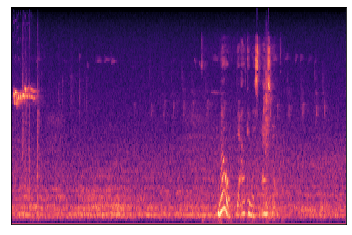

In [33]:
def plot_spectogram(df, row):
    librosa.display.specshow(librosa.power_to_db(df[row], ref=np.max))

    
plot_spectogram(df_mixed['mixed_array'],0)

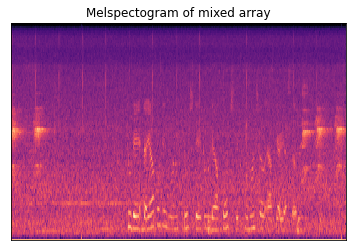

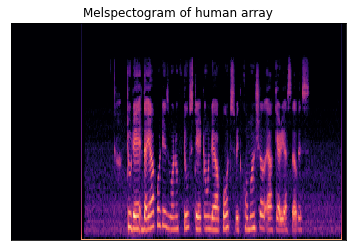

In [34]:
def plot_compare(row):
    fig, ax = plt.subplots()
    librosa.display.specshow(librosa.power_to_db(df_mixed['mixed_array'][row], ref=np.max), ax=ax)
    ax.set(title='Melspectogram of mixed array')

    fig, ax = plt.subplots()
    librosa.display.specshow(librosa.power_to_db(df_mixed['human_array'][row], ref=np.max), ax=ax)
    ax.set(title='Melspectogram of human array')
    
    
plot_compare(15)

In [35]:
df_mixed['human_array'][0].shape

(128, 869)

In [36]:
#create a file
picklefile = open('df_mixed.pkl', 'wb')
#pickle the dataframe
pickle.dump(df_mixed, picklefile)
#close file
picklefile.close()

In [37]:
df_mixed['human_array'][0].nbytes

222464